This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
from collections import Counter, defaultdict
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [3]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [4]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [5]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [6]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


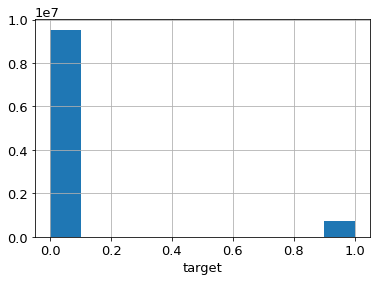

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8904038900654864


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,id,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
train['country_pair'] = train[['country', 'near_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)
test['country_pair'] = test[['country', 'near_country']].apply(lambda x: tuple(sorted(list(x))), axis = 1)

In [ ]:
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0,country_pair
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,1.000000,0,1.000000,33,33,33,0.000000,1.000000,1.000000,"(ad, ad)"
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,0.451613,17,0.406746,7,24,7,0.708333,1.000000,0.291667,"(ad, ad)"
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,0.300000,8,0.670034,5,11,9,0.727273,0.555556,0.454545,"(ad, ad)"
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,1.000000,0,1.000000,9,9,9,0.000000,1.000000,1.000000,"(ad, ad)"
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,1.000000,0,1.000000,20,20,20,0.000000,1.000000,1.000000,"(ad, ad)"


In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id", "country_pair"]]
test = test[features + ["id", "near_id", "country_pair"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248613 entries, 0 to 10248612
Data columns (total 60 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
distrs = [get_distribution(train["target"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train, train["target"], train["country_pair"], k=CFG.n_splits, seed=CFG.seed)):
    train.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train.loc[dev_ind, "target"], train.loc[val_ind, "target"]
    dev_groups, val_groups = train.loc[dev_ind, "country_pair"], train.loc[val_ind, "country_pair"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train["target"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,93.02%,6.98%
development set - fold 0,92.84%,7.16%
validation set - fold 0,93.40%,6.60%
development set - fold 1,93.38%,6.62%
validation set - fold 1,92.32%,7.68%
development set - fold 2,92.86%,7.14%
validation set - fold 2,93.36%,6.64%


# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0731176
[100]	valid_0's binary_logloss: 0.0722499

== fold 1 ==
[50]	valid_0's binary_logloss: 0.113226
[100]	valid_0's binary_logloss: 0.111359
[150]	valid_0's binary_logloss: 0.110563
[200]	valid_0's binary_logloss: 0.110217

== fold 2 ==
[50]	valid_0's binary_logloss: 0.0937211
[100]	valid_0's binary_logloss: 0.0922787
[150]	valid_0's binary_logloss: 0.0919831
[200]	valid_0's binary_logloss: 0.0916684
[250]	valid_0's binary_logloss: 0.0913029
[300]	valid_0's binary_logloss: 0.0912899

CV-accuracy: 0.966297585829419


In [ ]:
train["pred"] = oof[:, -1]

In [ ]:
train["max_pred"] = train["id"].map(dict(train.groupby("id")["pred"].max()))

# Check CV

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > x)].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 14:58:43,831] A new study created in memory with name: no-name-4c9d23a8-03b9-4460-963c-cf62771da597
[I 2022-05-14 14:59:05,689] Trial 0 finished with value: 0.7918654604085036 and parameters: {'threshold': 0.3048636423653204}. Best is trial 0 with value: 0.7918654604085036.


CV: 0.791865, precision: 0.945181, recall: 0.837107


[I 2022-05-14 14:59:25,621] Trial 1 finished with value: 0.7950883517421852 and parameters: {'threshold': 0.4582470976368068}. Best is trial 1 with value: 0.7950883517421852.


CV: 0.795088, precision: 0.962684, recall: 0.825945


[I 2022-05-14 14:59:44,315] Trial 2 finished with value: 0.7942347713810968 and parameters: {'threshold': 0.5385890087312856}. Best is trial 1 with value: 0.7950883517421852.


CV: 0.794235, precision: 0.970039, recall: 0.818915


[I 2022-05-14 15:00:03,480] Trial 3 finished with value: 0.7934475362757183 and parameters: {'threshold': 0.5677871546524372}. Best is trial 1 with value: 0.7950883517421852.


CV: 0.793448, precision: 0.972508, recall: 0.816040


[I 2022-05-14 15:00:25,480] Trial 4 finished with value: 0.7887641432577776 and parameters: {'threshold': 0.2509583576777067}. Best is trial 1 with value: 0.7950883517421852.


CV: 0.788764, precision: 0.936998, recall: 0.840555


[I 2022-05-14 15:00:50,181] Trial 5 finished with value: 0.7697331271477831 and parameters: {'threshold': 0.105488052789666}. Best is trial 1 with value: 0.7950883517421852.


CV: 0.769733, precision: 0.899962, recall: 0.849829


[I 2022-05-14 15:01:10,790] Trial 6 finished with value: 0.7951053592258319 and parameters: {'threshold': 0.46254221175168286}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.795105, precision: 0.963113, recall: 0.825612


[I 2022-05-14 15:01:25,774] Trial 7 finished with value: 0.7721044236579326 and parameters: {'threshold': 0.8223520933131839}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.772104, precision: 0.991053, recall: 0.779464


[I 2022-05-14 15:01:48,848] Trial 8 finished with value: 0.7872986833343857 and parameters: {'threshold': 0.2314738457798149}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.787299, precision: 0.933539, recall: 0.841779


[I 2022-05-14 15:02:15,092] Trial 9 finished with value: 0.7629116122342231 and parameters: {'threshold': 0.08119951514922452}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.762912, precision: 0.888786, recall: 0.851379


[I 2022-05-14 15:02:27,243] Trial 10 finished with value: 0.72432119430157 and parameters: {'threshold': 0.9465196123422412}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.724321, precision: 0.998036, recall: 0.725895


[I 2022-05-14 15:02:45,106] Trial 11 finished with value: 0.7893450238120533 and parameters: {'threshold': 0.6602866063551364}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.789345, precision: 0.980055, recall: 0.805747


[I 2022-05-14 15:03:05,150] Trial 12 finished with value: 0.7947302440996278 and parameters: {'threshold': 0.40949429169878565}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.794730, precision: 0.957693, recall: 0.829755


[I 2022-05-14 15:03:22,055] Trial 13 finished with value: 0.7867080142118043 and parameters: {'threshold': 0.699610307540395}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.786708, precision: 0.983132, recall: 0.800684


[I 2022-05-14 15:03:42,133] Trial 14 finished with value: 0.7946672928012831 and parameters: {'threshold': 0.4032778402307551}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.794667, precision: 0.957029, recall: 0.830237


[I 2022-05-14 15:04:02,133] Trial 15 finished with value: 0.7950212930680118 and parameters: {'threshold': 0.43553907961252086}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.795021, precision: 0.960428, recall: 0.827776


[I 2022-05-14 15:04:20,024] Trial 16 finished with value: 0.7914686249927049 and parameters: {'threshold': 0.6200470396754124}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.791469, precision: 0.976815, recall: 0.810489


[I 2022-05-14 15:04:36,521] Trial 17 finished with value: 0.7793866567492317 and parameters: {'threshold': 0.7742607016739651}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.779387, precision: 0.988160, recall: 0.789173


[I 2022-05-14 15:04:57,383] Trial 18 finished with value: 0.7928391069491554 and parameters: {'threshold': 0.32923414582719307}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.792839, precision: 0.948397, recall: 0.835475


[I 2022-05-14 15:05:16,788] Trial 19 finished with value: 0.7948760303080061 and parameters: {'threshold': 0.5053633532732774}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.794876, precision: 0.967173, recall: 0.821976


[I 2022-05-14 15:05:39,513] Trial 20 finished with value: 0.783292038775763 and parameters: {'threshold': 0.1893049968170088}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.783292, precision: 0.924935, recall: 0.844457


[I 2022-05-14 15:05:59,659] Trial 21 finished with value: 0.7947633540548148 and parameters: {'threshold': 0.4114818517810057}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.794763, precision: 0.957916, recall: 0.829600


[I 2022-05-14 15:06:19,953] Trial 22 finished with value: 0.7950484229211812 and parameters: {'threshold': 0.45468231303137613}. Best is trial 6 with value: 0.7951053592258319.


CV: 0.795048, precision: 0.962321, recall: 0.826210


[I 2022-05-14 15:06:39,221] Trial 23 finished with value: 0.7951066130009493 and parameters: {'threshold': 0.4710932841370155}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795107, precision: 0.963952, recall: 0.824910


[I 2022-05-14 15:06:59,902] Trial 24 finished with value: 0.7930737263768802 and parameters: {'threshold': 0.3354476387482549}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.793074, precision: 0.949173, recall: 0.835069


[I 2022-05-14 15:07:18,340] Trial 25 finished with value: 0.793631959886082 and parameters: {'threshold': 0.5616754118126889}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.793632, precision: 0.972009, recall: 0.816650


[I 2022-05-14 15:07:35,044] Trial 26 finished with value: 0.7812751913014923 and parameters: {'threshold': 0.7581520894085498}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.781275, precision: 0.987109, recall: 0.791937


[I 2022-05-14 15:07:54,163] Trial 27 finished with value: 0.7949225738711055 and parameters: {'threshold': 0.4979538028688505}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794923, precision: 0.966487, recall: 0.822605


[I 2022-05-14 15:08:24,278] Trial 28 finished with value: 0.703108602984526 and parameters: {'threshold': 0.011051487267155657}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.703109, precision: 0.801622, recall: 0.856351


[I 2022-05-14 15:08:45,558] Trial 29 finished with value: 0.7910989308890454 and parameters: {'threshold': 0.2889208096808915}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.791099, precision: 0.942934, recall: 0.838150


[I 2022-05-14 15:09:06,897] Trial 30 finished with value: 0.7935240391877847 and parameters: {'threshold': 0.3505356736085631}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.793524, precision: 0.950999, recall: 0.834026


[I 2022-05-14 15:09:26,024] Trial 31 finished with value: 0.7950790976305134 and parameters: {'threshold': 0.4773453007261796}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795079, precision: 0.964541, recall: 0.824397


[I 2022-05-14 15:09:43,986] Trial 32 finished with value: 0.7921829345750211 and parameters: {'threshold': 0.6040975861248254}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.792183, precision: 0.975510, recall: 0.812282


[I 2022-05-14 15:10:02,952] Trial 33 finished with value: 0.794994040468966 and parameters: {'threshold': 0.49003231122964114}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794994, precision: 0.965747, recall: 0.823302


[I 2022-05-14 15:10:21,249] Trial 34 finished with value: 0.7933523054924474 and parameters: {'threshold': 0.5713676457275911}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.793352, precision: 0.972808, recall: 0.815690


[I 2022-05-14 15:10:41,595] Trial 35 finished with value: 0.7940919620031006 and parameters: {'threshold': 0.3717077815301341}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794092, precision: 0.953485, recall: 0.832561


[I 2022-05-14 15:11:00,342] Trial 36 finished with value: 0.794751382596323 and parameters: {'threshold': 0.5137563208348782}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794751, precision: 0.967930, recall: 0.821212


[I 2022-05-14 15:11:22,596] Trial 37 finished with value: 0.7901557674298021 and parameters: {'threshold': 0.2729574162388478}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.790156, precision: 0.940521, recall: 0.839150


[I 2022-05-14 15:11:45,182] Trial 38 finished with value: 0.7819732588978331 and parameters: {'threshold': 0.17772077869057862}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.781973, precision: 0.922243, recall: 0.845209


[I 2022-05-14 15:12:04,453] Trial 39 finished with value: 0.7950988108785861 and parameters: {'threshold': 0.46797254793465554}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795099, precision: 0.963645, recall: 0.825155


[I 2022-05-14 15:12:22,049] Trial 40 finished with value: 0.7896944601350143 and parameters: {'threshold': 0.6543404298508728}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.789694, precision: 0.979579, recall: 0.806477


[I 2022-05-14 15:12:41,465] Trial 41 finished with value: 0.7951005418000608 and parameters: {'threshold': 0.46380698196353987}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795101, precision: 0.963235, recall: 0.825505


[I 2022-05-14 15:13:00,010] Trial 42 finished with value: 0.7943004517343875 and parameters: {'threshold': 0.5356635605047024}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794300, precision: 0.969783, recall: 0.819196


[I 2022-05-14 15:13:19,410] Trial 43 finished with value: 0.795070996633417 and parameters: {'threshold': 0.4455842551187494}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795071, precision: 0.961449, recall: 0.826961


[I 2022-05-14 15:13:39,615] Trial 44 finished with value: 0.7946285945907969 and parameters: {'threshold': 0.402047234387835}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794629, precision: 0.956872, recall: 0.830331


[I 2022-05-14 15:13:57,519] Trial 45 finished with value: 0.7927466967522454 and parameters: {'threshold': 0.5889397973759939}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.792747, precision: 0.974276, recall: 0.813865


[I 2022-05-14 15:14:18,948] Trial 46 finished with value: 0.7942076762632411 and parameters: {'threshold': 0.37655815585547125}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794208, precision: 0.954057, recall: 0.832210


[I 2022-05-14 15:14:35,461] Trial 47 finished with value: 0.7881167061012632 and parameters: {'threshold': 0.6800985186988011}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.788117, precision: 0.981663, recall: 0.803249


[I 2022-05-14 15:14:58,412] Trial 48 finished with value: 0.7867995197539145 and parameters: {'threshold': 0.22531325063406016}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.786800, precision: 0.932416, recall: 0.842159


[I 2022-05-14 15:15:17,119] Trial 49 finished with value: 0.794171482726634 and parameters: {'threshold': 0.5410681719103795}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794171, precision: 0.970252, recall: 0.818675


[I 2022-05-14 15:15:26,799] Trial 50 finished with value: 0.6992515727216346 and parameters: {'threshold': 0.9705527890005479}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.699252, precision: 0.999182, recall: 0.699912


[I 2022-05-14 15:15:46,053] Trial 51 finished with value: 0.7950922532980352 and parameters: {'threshold': 0.4594204243553593}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795092, precision: 0.962798, recall: 0.825855


[I 2022-05-14 15:16:05,425] Trial 52 finished with value: 0.795079909618623 and parameters: {'threshold': 0.45658473524064846}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.795080, precision: 0.962515, recall: 0.826078


[I 2022-05-14 15:16:25,905] Trial 53 finished with value: 0.7949502447679748 and parameters: {'threshold': 0.4301455277992522}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794950, precision: 0.959855, recall: 0.828186


[I 2022-05-14 15:16:43,858] Trial 54 finished with value: 0.7943734812208286 and parameters: {'threshold': 0.5328307893406345}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794373, precision: 0.969552, recall: 0.819464


[I 2022-05-14 15:17:05,483] Trial 55 finished with value: 0.7924022130515289 and parameters: {'threshold': 0.3181700337006167}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.792402, precision: 0.946967, recall: 0.836197


[I 2022-05-14 15:17:25,837] Trial 56 finished with value: 0.7940290381654336 and parameters: {'threshold': 0.3699153907123789}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.794029, precision: 0.953258, recall: 0.832689


[I 2022-05-14 15:17:43,518] Trial 57 finished with value: 0.791225607290978 and parameters: {'threshold': 0.6257567895524013}. Best is trial 23 with value: 0.7951066130009493.


CV: 0.791226, precision: 0.977286, recall: 0.809845


[I 2022-05-14 15:18:02,787] Trial 58 finished with value: 0.7951089106027907 and parameters: {'threshold': 0.47102473870606526}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795109, precision: 0.963945, recall: 0.824918


[I 2022-05-14 15:18:22,014] Trial 59 finished with value: 0.7950975748914465 and parameters: {'threshold': 0.4682586492964932}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795098, precision: 0.963673, recall: 0.825133


[I 2022-05-14 15:18:42,651] Trial 60 finished with value: 0.7946877485993046 and parameters: {'threshold': 0.4044385790203635}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794688, precision: 0.957155, recall: 0.830157


[I 2022-05-14 15:19:01,922] Trial 61 finished with value: 0.7950856325168146 and parameters: {'threshold': 0.47563747619935853}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795086, precision: 0.964373, recall: 0.824541


[I 2022-05-14 15:19:20,730] Trial 62 finished with value: 0.7946888061019844 and parameters: {'threshold': 0.5171268409268903}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794689, precision: 0.968220, recall: 0.820898


[I 2022-05-14 15:19:40,477] Trial 63 finished with value: 0.7949764808359375 and parameters: {'threshold': 0.4319400329593793}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794976, precision: 0.960049, recall: 0.828049


[I 2022-05-14 15:19:58,809] Trial 64 finished with value: 0.7936636610330587 and parameters: {'threshold': 0.5596503109034567}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.793664, precision: 0.971813, recall: 0.816851


[I 2022-05-14 15:20:17,978] Trial 65 finished with value: 0.7950820731735285 and parameters: {'threshold': 0.47523866168101975}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795082, precision: 0.964338, recall: 0.824569


[I 2022-05-14 15:20:37,911] Trial 66 finished with value: 0.7946007276157387 and parameters: {'threshold': 0.40010535097783584}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794601, precision: 0.956662, recall: 0.830468


[I 2022-05-14 15:20:57,974] Trial 67 finished with value: 0.7951041479356585 and parameters: {'threshold': 0.4634041411667027}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795104, precision: 0.963201, recall: 0.825538


[I 2022-05-14 15:21:11,337] Trial 68 finished with value: 0.7576322994245435 and parameters: {'threshold': 0.8816459780792001}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.757632, precision: 0.994464, recall: 0.762164


[I 2022-05-14 15:21:31,315] Trial 69 finished with value: 0.7949019055477234 and parameters: {'threshold': 0.5020628749670193}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794902, precision: 0.966866, recall: 0.822258


[I 2022-05-14 15:21:51,829] Trial 70 finished with value: 0.7935571364661572 and parameters: {'threshold': 0.3514588345805836}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.793557, precision: 0.951110, recall: 0.833966


[I 2022-05-14 15:22:11,553] Trial 71 finished with value: 0.7950925777141691 and parameters: {'threshold': 0.4593267254849996}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795093, precision: 0.962789, recall: 0.825862


[I 2022-05-14 15:22:31,189] Trial 72 finished with value: 0.7949820177828617 and parameters: {'threshold': 0.43318230540381814}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794982, precision: 0.960174, recall: 0.827951


[I 2022-05-14 15:22:50,188] Trial 73 finished with value: 0.7949926850341408 and parameters: {'threshold': 0.489865910603101}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794993, precision: 0.965731, recall: 0.823314


[I 2022-05-14 15:23:08,353] Trial 74 finished with value: 0.7928869464202845 and parameters: {'threshold': 0.5847430805227406}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.792887, precision: 0.973923, recall: 0.814294


[I 2022-05-14 15:23:26,986] Trial 75 finished with value: 0.7940129231074812 and parameters: {'threshold': 0.546504053987777}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794013, precision: 0.970707, recall: 0.818135


[I 2022-05-14 15:23:47,011] Trial 76 finished with value: 0.7944663924834577 and parameters: {'threshold': 0.39050654961930537}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794466, precision: 0.955638, recall: 0.831176


[I 2022-05-14 15:24:04,660] Trial 77 finished with value: 0.79123998082994 and parameters: {'threshold': 0.6254630033771392}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.791240, precision: 0.977262, recall: 0.809879


[I 2022-05-14 15:24:23,410] Trial 78 finished with value: 0.7946108880268337 and parameters: {'threshold': 0.5203387516230269}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794611, precision: 0.968480, recall: 0.820604


[I 2022-05-14 15:24:43,625] Trial 79 finished with value: 0.7950741475033581 and parameters: {'threshold': 0.4528319525968776}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.795074, precision: 0.962154, recall: 0.826375


[I 2022-05-14 15:25:03,517] Trial 80 finished with value: 0.7948609467750256 and parameters: {'threshold': 0.42222893705486014}. Best is trial 58 with value: 0.7951089106027907.


CV: 0.794861, precision: 0.959012, recall: 0.828791


[I 2022-05-14 15:25:22,914] Trial 81 finished with value: 0.7951160855104481 and parameters: {'threshold': 0.46550120591467126}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795116, precision: 0.963407, recall: 0.825377


[I 2022-05-14 15:25:42,419] Trial 82 finished with value: 0.795099909794298 and parameters: {'threshold': 0.4718323668193133}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795100, precision: 0.964018, recall: 0.824851


[I 2022-05-14 15:26:01,333] Trial 83 finished with value: 0.7949627408030112 and parameters: {'threshold': 0.49581390049699725}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794963, precision: 0.966285, recall: 0.822817


[I 2022-05-14 15:26:21,608] Trial 84 finished with value: 0.7938236910565433 and parameters: {'threshold': 0.3609578276222599}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.793824, precision: 0.952232, recall: 0.833310


[I 2022-05-14 15:26:42,619] Trial 85 finished with value: 0.791673577052693 and parameters: {'threshold': 0.3004884348850293}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.791674, precision: 0.944590, recall: 0.837385


[I 2022-05-14 15:27:00,898] Trial 86 finished with value: 0.7936009876673134 and parameters: {'threshold': 0.5629249182092975}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.793601, precision: 0.972115, recall: 0.816530


[I 2022-05-14 15:27:20,986] Trial 87 finished with value: 0.7950941188513742 and parameters: {'threshold': 0.4743346561998459}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795094, precision: 0.964260, recall: 0.824645


[I 2022-05-14 15:27:41,342] Trial 88 finished with value: 0.7943352601722705 and parameters: {'threshold': 0.38391427374763754}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794335, precision: 0.954889, recall: 0.831657


[I 2022-05-14 15:28:01,186] Trial 89 finished with value: 0.7948062926924349 and parameters: {'threshold': 0.4170968164936264}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794806, precision: 0.958477, recall: 0.829177


[I 2022-05-14 15:28:21,868] Trial 90 finished with value: 0.7927810404351374 and parameters: {'threshold': 0.32780814145879844}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.792781, precision: 0.948217, recall: 0.835563


[I 2022-05-14 15:28:40,994] Trial 91 finished with value: 0.795017761604337 and parameters: {'threshold': 0.48172941868331437}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795018, precision: 0.964943, recall: 0.824000


[I 2022-05-14 15:29:00,284] Trial 92 finished with value: 0.7951059040684884 and parameters: {'threshold': 0.46330964145716125}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795106, precision: 0.963191, recall: 0.825547


[I 2022-05-14 15:29:19,886] Trial 93 finished with value: 0.7946069682333292 and parameters: {'threshold': 0.52057777938006}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794607, precision: 0.968504, recall: 0.820581


[I 2022-05-14 15:29:39,356] Trial 94 finished with value: 0.7950764164522509 and parameters: {'threshold': 0.45636591189923104}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795076, precision: 0.962494, recall: 0.826091


[I 2022-05-14 15:29:59,046] Trial 95 finished with value: 0.7950374488519257 and parameters: {'threshold': 0.4381004171775626}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.795037, precision: 0.960682, recall: 0.827575


[I 2022-05-14 15:30:18,425] Trial 96 finished with value: 0.7948581882271311 and parameters: {'threshold': 0.507433400500387}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794858, precision: 0.967368, recall: 0.821791


[I 2022-05-14 15:30:37,081] Trial 97 finished with value: 0.7940742540278839 and parameters: {'threshold': 0.5447469620198322}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794074, precision: 0.970568, recall: 0.818313


[I 2022-05-14 15:30:55,154] Trial 98 finished with value: 0.792276474444401 and parameters: {'threshold': 0.6018848031078965}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.792276, precision: 0.975325, recall: 0.812526


[I 2022-05-14 15:31:15,035] Trial 99 finished with value: 0.7947939514935809 and parameters: {'threshold': 0.4145305004813455}. Best is trial 81 with value: 0.7951160855104481.


CV: 0.794794, precision: 0.958222, recall: 0.829381


In [ ]:
threshold = study.best_params['threshold']
threshold

0.46550120591467126

In [ ]:
study.best_value

0.7951160855104481

In [ ]:
id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.795116, precision: 0.963407, recall: 0.825377


# Check Feature Importances

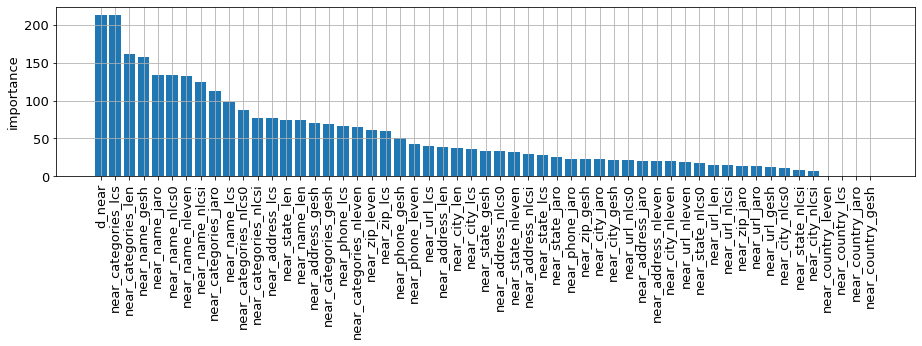

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > x)].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 15:31:36,264] A new study created in memory with name: no-name-5f10699d-0631-4f1d-8d39-519f94162d46


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:32:36,777] Trial 0 finished with value: 0.782694468435466 and parameters: {'threshold': 0.8183096137838838}. Best is trial 0 with value: 0.782694468435466.


CV: 0.782694, precision: 0.988655, recall: 0.792190


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:33:26,122] Trial 1 finished with value: 0.7398486662138808 and parameters: {'threshold': 0.9383926310387426}. Best is trial 0 with value: 0.782694468435466.


CV: 0.739849, precision: 0.996970, recall: 0.742318


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:34:50,365] Trial 2 finished with value: 0.7316978525132122 and parameters: {'threshold': 0.04294856432266014}. Best is trial 0 with value: 0.782694468435466.


CV: 0.731698, precision: 0.830771, recall: 0.868870


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.788824, precision: 0.920575, recall: 0.855391


[I 2022-05-14 15:36:05,572] Trial 3 finished with value: 0.7888239161364278 and parameters: {'threshold': 0.2343530836249078}. Best is trial 3 with value: 0.7888239161364278.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:36:56,384] Trial 4 finished with value: 0.7550636557027545 and parameters: {'threshold': 0.9137542241100398}. Best is trial 3 with value: 0.7888239161364278.


CV: 0.755064, precision: 0.995281, recall: 0.758962


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.791703, precision: 0.926708, recall: 0.853333


[I 2022-05-14 15:38:08,811] Trial 5 finished with value: 0.7917028575741033 and parameters: {'threshold': 0.2642213272062597}. Best is trial 5 with value: 0.7917028575741033.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:39:01,578] Trial 6 finished with value: 0.7652288356030728 and parameters: {'threshold': 0.8893667884542596}. Best is trial 5 with value: 0.7917028575741033.


CV: 0.765229, precision: 0.993604, recall: 0.770549


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:40:08,784] Trial 7 finished with value: 0.8013275073261596 and parameters: {'threshold': 0.4808665989970712}. Best is trial 7 with value: 0.8013275073261596.


CV: 0.801328, precision: 0.957616, recall: 0.837095


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.799271, precision: 0.946194, recall: 0.844714


[I 2022-05-14 15:41:18,212] Trial 8 finished with value: 0.7992706338844063 and parameters: {'threshold': 0.3868470495961235}. Best is trial 7 with value: 0.8013275073261596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.791338, precision: 0.925934, recall: 0.853604


[I 2022-05-14 15:42:30,211] Trial 9 finished with value: 0.7913380413964054 and parameters: {'threshold': 0.2600635205626465}. Best is trial 7 with value: 0.8013275073261596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.799138, precision: 0.972704, recall: 0.822023


[I 2022-05-14 15:43:31,654] Trial 10 finished with value: 0.7991383916449937 and parameters: {'threshold': 0.6297364290691569}. Best is trial 7 with value: 0.8013275073261596.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801467, precision: 0.961759, recall: 0.833686


[I 2022-05-14 15:44:37,987] Trial 11 finished with value: 0.801466860083581 and parameters: {'threshold': 0.5191587341768826}. Best is trial 11 with value: 0.801466860083581.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:45:41,930] Trial 12 finished with value: 0.800378801307054 and parameters: {'threshold': 0.5915068328011945}. Best is trial 11 with value: 0.801466860083581.


CV: 0.800379, precision: 0.968927, recall: 0.826444


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801501, precision: 0.960602, recall: 0.834713


[I 2022-05-14 15:46:45,981] Trial 13 finished with value: 0.8015013483408836 and parameters: {'threshold': 0.5077892759467291}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:47:47,205] Trial 14 finished with value: 0.7957739093599568 and parameters: {'threshold': 0.6952973735603141}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.795774, precision: 0.978858, recall: 0.813592


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:48:53,562] Trial 15 finished with value: 0.8013758984809239 and parameters: {'threshold': 0.48817879176498435}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801376, precision: 0.958434, recall: 0.836445


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:49:56,934] Trial 16 finished with value: 0.7923447853278129 and parameters: {'threshold': 0.7397516695244863}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.792345, precision: 0.982623, recall: 0.806973


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:51:05,860] Trial 17 finished with value: 0.7993125798770842 and parameters: {'threshold': 0.38841446083916037}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.799313, precision: 0.946399, recall: 0.844587


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:52:29,337] Trial 18 finished with value: 0.7529118911956131 and parameters: {'threshold': 0.07580715624111056}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.752912, precision: 0.861201, recall: 0.866409


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:53:36,988] Trial 19 finished with value: 0.7988714233855609 and parameters: {'threshold': 0.37693837225627724}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.798871, precision: 0.944822, recall: 0.845482


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:54:39,356] Trial 20 finished with value: 0.8006957500173683 and parameters: {'threshold': 0.5777168808267528}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.800696, precision: 0.967582, recall: 0.827905


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801181, precision: 0.955907, recall: 0.838408


[I 2022-05-14 15:55:45,731] Trial 21 finished with value: 0.8011806859838884 and parameters: {'threshold': 0.46571840516401075}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:56:51,098] Trial 22 finished with value: 0.8014427310280832 and parameters: {'threshold': 0.5254352448626016}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801443, precision: 0.962398, recall: 0.833118


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:57:55,011] Trial 23 finished with value: 0.80098297947187 and parameters: {'threshold': 0.5604700733904037}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.800983, precision: 0.965872, recall: 0.829675


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.796559, precision: 0.977886, recall: 0.815189


[I 2022-05-14 15:58:55,306] Trial 24 finished with value: 0.7965586005488065 and parameters: {'threshold': 0.6838282603613701}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800373, precision: 0.951217, recall: 0.841597


[I 2022-05-14 16:00:03,197] Trial 25 finished with value: 0.8003733478277877 and parameters: {'threshold': 0.426686078251596}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.795921, precision: 0.936326, recall: 0.849631


[I 2022-05-14 16:01:14,294] Trial 26 finished with value: 0.7959214067476956 and parameters: {'threshold': 0.3187798703737773}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:02:30,443] Trial 27 finished with value: 0.7770332237485087 and parameters: {'threshold': 0.15549347438352584}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.777033, precision: 0.899117, recall: 0.860816


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:03:35,060] Trial 28 finished with value: 0.8014379280630691 and parameters: {'threshold': 0.5246164270358911}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801438, precision: 0.962298, recall: 0.833199


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:04:39,068] Trial 29 finished with value: 0.7904848935228274 and parameters: {'threshold': 0.7592934387597083}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.790485, precision: 0.984206, recall: 0.803776


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:05:35,573] Trial 30 finished with value: 0.7799047516320664 and parameters: {'threshold': 0.8335322700402783}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.779905, precision: 0.989712, recall: 0.788502


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801449, precision: 0.962390, recall: 0.833131


[I 2022-05-14 16:06:42,832] Trial 31 finished with value: 0.8014493071626468 and parameters: {'threshold': 0.5253391414846127}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.799727, precision: 0.970946, recall: 0.824082


[I 2022-05-14 16:07:44,039] Trial 32 finished with value: 0.7997272528889057 and parameters: {'threshold': 0.6122848166360896}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:08:45,740] Trial 33 finished with value: 0.7977533407399253 and parameters: {'threshold': 0.6596242577928559}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.797753, precision: 0.975509, recall: 0.818313


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:09:25,770] Trial 34 finished with value: 0.6700080541710696 and parameters: {'threshold': 0.9885912660513616}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.670008, precision: 0.999788, recall: 0.670180


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:10:30,314] Trial 35 finished with value: 0.8011457395547817 and parameters: {'threshold': 0.5473580633827786}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801146, precision: 0.964557, recall: 0.830971


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:11:40,181] Trial 36 finished with value: 0.7963652609170319 and parameters: {'threshold': 0.3264279917679473}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.796365, precision: 0.937528, recall: 0.849082


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:12:47,051] Trial 37 finished with value: 0.8007101553922807 and parameters: {'threshold': 0.43907157797868496}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.800710, precision: 0.952763, recall: 0.840619


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:13:52,200] Trial 38 finished with value: 0.8014618297473554 and parameters: {'threshold': 0.5199214642854498}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801462, precision: 0.961835, recall: 0.833612


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.797113, precision: 0.939515, recall: 0.848167


[I 2022-05-14 16:15:01,416] Trial 39 finished with value: 0.7971129369375889 and parameters: {'threshold': 0.33964326677035417}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:16:16,930] Trial 40 finished with value: 0.7831066971779532 and parameters: {'threshold': 0.19081568884311462}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.783107, precision: 0.909803, recall: 0.858335


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:17:23,271] Trial 41 finished with value: 0.8014442246551473 and parameters: {'threshold': 0.5007675038907098}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801444, precision: 0.959817, recall: 0.835333


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:18:28,268] Trial 42 finished with value: 0.801474574836209 and parameters: {'threshold': 0.5021117314073257}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801475, precision: 0.959973, recall: 0.835228


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800454, precision: 0.951557, recall: 0.841389


[I 2022-05-14 16:19:35,686] Trial 43 finished with value: 0.8004542329422059 and parameters: {'threshold': 0.42931777953314054}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:20:38,553] Trial 44 finished with value: 0.7994718087889426 and parameters: {'threshold': 0.6198753189481526}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.799472, precision: 0.971710, recall: 0.823185


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:21:46,648] Trial 45 finished with value: 0.8010444875664862 and parameters: {'threshold': 0.45820286259396253}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801044, precision: 0.955029, recall: 0.839018


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:22:51,602] Trial 46 finished with value: 0.8009853232085684 and parameters: {'threshold': 0.5608255674772349}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.800985, precision: 0.965918, recall: 0.829638


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.793167, precision: 0.981861, recall: 0.808445


[I 2022-05-14 16:23:55,634] Trial 47 finished with value: 0.7931668106063335 and parameters: {'threshold': 0.7306432573716011}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:25:05,084] Trial 48 finished with value: 0.7997257776837818 and parameters: {'threshold': 0.40158915328145567}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.799726, precision: 0.948085, recall: 0.843597


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801431, precision: 0.959786, recall: 0.835349


[I 2022-05-14 16:26:10,440] Trial 49 finished with value: 0.8014311166316841 and parameters: {'threshold': 0.5004865083754116}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:27:14,301] Trial 50 finished with value: 0.7982227183572388 and parameters: {'threshold': 0.6507951533715743}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.798223, precision: 0.974688, recall: 0.819454


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:28:18,886] Trial 51 finished with value: 0.8014295944499202 and parameters: {'threshold': 0.4932768035489605}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801430, precision: 0.959022, recall: 0.835996


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:29:24,592] Trial 52 finished with value: 0.8014494640703009 and parameters: {'threshold': 0.5203743653329418}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801449, precision: 0.961874, recall: 0.833567


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:30:28,296] Trial 53 finished with value: 0.8005976651903182 and parameters: {'threshold': 0.5811944660257159}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.800598, precision: 0.967919, recall: 0.827514


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:31:33,759] Trial 54 finished with value: 0.8014201442026971 and parameters: {'threshold': 0.5280192820061831}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801420, precision: 0.962645, recall: 0.832886


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:32:41,721] Trial 55 finished with value: 0.798046285417044 and parameters: {'threshold': 0.35878274258359777}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.798046, precision: 0.942280, recall: 0.846785


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:33:45,580] Trial 56 finished with value: 0.8001265349125019 and parameters: {'threshold': 0.6006174539351701}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.800127, precision: 0.969801, recall: 0.825444


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:34:52,905] Trial 57 finished with value: 0.8010700191631789 and parameters: {'threshold': 0.4588276909192613}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801070, precision: 0.955112, recall: 0.838973


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:35:57,991] Trial 58 finished with value: 0.8014016506700699 and parameters: {'threshold': 0.5314870147758983}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801402, precision: 0.962989, recall: 0.832573


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:37:08,488] Trial 59 finished with value: 0.7941875811016312 and parameters: {'threshold': 0.29331506233179494}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.794188, precision: 0.932085, recall: 0.851395


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:38:16,696] Trial 60 finished with value: 0.7999990642364544 and parameters: {'threshold': 0.41062697052096986}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.799999, precision: 0.949266, recall: 0.842870


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:39:22,955] Trial 61 finished with value: 0.8014262394727699 and parameters: {'threshold': 0.49507200309239774}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801426, precision: 0.959206, recall: 0.835837


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:40:30,039] Trial 62 finished with value: 0.8012823442879851 and parameters: {'threshold': 0.4745862441000317}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.801282, precision: 0.956918, recall: 0.837649


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800888, precision: 0.966429, recall: 0.829089


[I 2022-05-14 16:41:33,934] Trial 63 finished with value: 0.8008875289116667 and parameters: {'threshold': 0.5661495074931433}. Best is trial 13 with value: 0.8015013483408836.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:42:36,694] Trial 64 finished with value: 0.7988415333367305 and parameters: {'threshold': 0.6371744205191011}. Best is trial 13 with value: 0.8015013483408836.


CV: 0.798842, precision: 0.973405, recall: 0.821159


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801534, precision: 0.961086, recall: 0.834329


[I 2022-05-14 16:43:42,974] Trial 65 finished with value: 0.8015342844901335 and parameters: {'threshold': 0.5123461018769547}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:44:45,801] Trial 66 finished with value: 0.800373637275953 and parameters: {'threshold': 0.5917485031635674}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800374, precision: 0.968951, recall: 0.826418


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:45:47,258] Trial 67 finished with value: 0.7962592703452328 and parameters: {'threshold': 0.6882737372001815}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.796259, precision: 0.978267, recall: 0.814577


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:46:55,714] Trial 68 finished with value: 0.800868506093098 and parameters: {'threshold': 0.4485498511543699}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800869, precision: 0.953894, recall: 0.839816


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801508, precision: 0.961558, recall: 0.833892


[I 2022-05-14 16:48:01,841] Trial 69 finished with value: 0.8015076486115549 and parameters: {'threshold': 0.5169590529447486}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:49:11,811] Trial 70 finished with value: 0.7987650471735952 and parameters: {'threshold': 0.3736575112884154}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.798765, precision: 0.944368, recall: 0.845752


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801440, precision: 0.962066, recall: 0.833400


[I 2022-05-14 16:50:17,590] Trial 71 finished with value: 0.8014398750855878 and parameters: {'threshold': 0.5222803414861226}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801089, precision: 0.965154, recall: 0.830410


[I 2022-05-14 16:51:23,023] Trial 72 finished with value: 0.8010885968290092 and parameters: {'threshold': 0.5534699453303766}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:52:29,115] Trial 73 finished with value: 0.8012803180367603 and parameters: {'threshold': 0.4743710093591263}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801280, precision: 0.956894, recall: 0.837666


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:53:37,793] Trial 74 finished with value: 0.8001298138114528 and parameters: {'threshold': 0.4175174532769026}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800130, precision: 0.950067, recall: 0.842318


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:54:44,328] Trial 75 finished with value: 0.8014209410125442 and parameters: {'threshold': 0.5270746933705075}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801421, precision: 0.962549, recall: 0.832967


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:55:46,339] Trial 76 finished with value: 0.8005652765415544 and parameters: {'threshold': 0.5822928822438201}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800565, precision: 0.968038, recall: 0.827383


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.799817, precision: 0.970726, recall: 0.824359


[I 2022-05-14 16:56:48,212] Trial 77 finished with value: 0.7998169301735424 and parameters: {'threshold': 0.6100470035028772}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:57:55,857] Trial 78 finished with value: 0.8015121064586022 and parameters: {'threshold': 0.516692154651841}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801512, precision: 0.961535, recall: 0.833918


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 16:58:56,964] Trial 79 finished with value: 0.7976951782678819 and parameters: {'threshold': 0.6606106725300821}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.797695, precision: 0.975608, recall: 0.818171


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801487, precision: 0.960008, recall: 0.835207


[I 2022-05-14 17:00:02,553] Trial 80 finished with value: 0.8014872163492318 and parameters: {'threshold': 0.5023649000125991}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:01:09,653] Trial 81 finished with value: 0.8008314055246614 and parameters: {'threshold': 0.44522349906321335}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800831, precision: 0.953516, recall: 0.840098


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801486, precision: 0.960527, recall: 0.834763


[I 2022-05-14 17:02:16,165] Trial 82 finished with value: 0.801485752317901 and parameters: {'threshold': 0.5071940369652718}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:03:20,440] Trial 83 finished with value: 0.801136287232496 and parameters: {'threshold': 0.547558318275242}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801136, precision: 0.964570, recall: 0.830949


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801411, precision: 0.959614, recall: 0.835474


[I 2022-05-14 17:04:26,430] Trial 84 finished with value: 0.8014109475099623 and parameters: {'threshold': 0.49893423719496655}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:05:32,714] Trial 85 finished with value: 0.8013495335522485 and parameters: {'threshold': 0.484772632669466}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801350, precision: 0.958044, recall: 0.836747


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:06:41,634] Trial 86 finished with value: 0.7995041172127506 and parameters: {'threshold': 0.3952760081952823}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.799504, precision: 0.947248, recall: 0.844071


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:07:49,681] Trial 87 finished with value: 0.8011445465633734 and parameters: {'threshold': 0.46353624629968726}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801145, precision: 0.955662, recall: 0.838579


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:09:17,019] Trial 88 finished with value: 0.687546956507797 and parameters: {'threshold': 0.015153177851838673}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.687547, precision: 0.771316, recall: 0.871409


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.800477, precision: 0.951658, recall: 0.841330


[I 2022-05-14 17:10:26,568] Trial 89 finished with value: 0.8004765982772382 and parameters: {'threshold': 0.4300773119751566}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:11:31,191] Trial 90 finished with value: 0.8008163557941869 and parameters: {'threshold': 0.5715657657128611}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800816, precision: 0.966971, recall: 0.828547


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:12:37,811] Trial 91 finished with value: 0.8015041896521775 and parameters: {'threshold': 0.5090018375590318}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801504, precision: 0.960727, recall: 0.834608


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801399, precision: 0.963233, recall: 0.832362


[I 2022-05-14 17:13:42,466] Trial 92 finished with value: 0.8013985774505871 and parameters: {'threshold': 0.5337794783486306}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801527, precision: 0.960933, recall: 0.834454


[I 2022-05-14 17:14:46,881] Trial 93 finished with value: 0.8015272410363999 and parameters: {'threshold': 0.5109102736670855}. Best is trial 65 with value: 0.8015342844901335.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:15:54,194] Trial 94 finished with value: 0.801505327318175 and parameters: {'threshold': 0.50807336673975}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801505, precision: 0.960633, recall: 0.834690


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:17:00,062] Trial 95 finished with value: 0.8015049210893155 and parameters: {'threshold': 0.5078957398012813}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801505, precision: 0.960616, recall: 0.834705


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:18:06,059] Trial 96 finished with value: 0.8012916941887146 and parameters: {'threshold': 0.47579646609706105}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801292, precision: 0.957044, recall: 0.837548


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:19:11,530] Trial 97 finished with value: 0.8010885188087236 and parameters: {'threshold': 0.5523500135787478}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801089, precision: 0.965034, recall: 0.830510


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:20:19,951] Trial 98 finished with value: 0.8006691794304269 and parameters: {'threshold': 0.43715022321643904}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.800669, precision: 0.952524, recall: 0.840782


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 17:21:27,877] Trial 99 finished with value: 0.8014848983532173 and parameters: {'threshold': 0.5030919852913921}. Best is trial 65 with value: 0.8015342844901335.


CV: 0.801485, precision: 0.960079, recall: 0.835145


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5123461018769547

In [ ]:
study.best_value

0.8015342844901335

In [ ]:
id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.801534, precision: 0.961086, recall: 0.834329


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
test["max_pred"] = test["id"].map(dict(test.groupby("id")["pred"].max()))

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[(test["pred"] == test["max_pred"]) & (test["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
